# NPLM Test notebook

## Imports

In [11]:
import torch 
import h5py
import os 

import scipy.stats as stats
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep

In [12]:
from plot_utils import plot_ref_data, plot_ref_data_reco, plot_loss_history
from analysis_utils import compute_df, produce_bins, save_binning, load_binning

## Config

In [13]:
# use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [14]:
hep.style.use(hep.style.CMS)
mpl.rcParams["figure.dpi"] = 60

## Constants

In [15]:
# Set random seed
SEED = 1231244
torch.manual_seed(SEED)
np.random.seed(SEED)

# Plotting parameters
FONTSIZE  = 36
FIGSIZE   = (14, 12)
PALETTE_1 = [
    "#1f77b4", # 0
    "#4876bf", # 1 
    "#6c74c5", # 2
    "#8f6fc6", # 3
    "#b067c0", # 4
    "#cd5fb4", # 5
    "#e657a3", # 6
    "#f9528d", # 7
    "#ff5474", # 8
    "#ff5d58", # 9
    "#ff6c3a", # 10
    "#ff7f0e", # 11
]
PALETTE_2 = [
    "#494B69", # 0
    "#695D7A", # 1
    "#9F5B72", # 2
    "#D8707C", # 3
    "#FDA85A", # 4
    "#FDCD5A", # 5
]
PALETTE_3 = [
    "midnightblue",   # 0
    "#1f78b4",        # 1
    "lightseagreen",  # 2
    "mediumseagreen", # 3
    "darkseagreen",   # 4
]

# Statistics                                                                                                                                                   
N_REF      = 200000
N_BKG      = 2000
N_SIG      = 10       
SIG_LOC    = 6.4
SIG_STD    = 0.16
# Samples weights N_D/N_R
N_R        = N_REF
N_D        = N_BKG

# Training parameters
N_EPOCHS   = 200000
PATIENCE   = 5000

# Network parameters
N_INPUTS     = 1
N_OUTPUTS    = 1
ARCHITECTURE = [N_INPUTS, 4, N_OUTPUTS]
WCLIP        = 9
ACTIVATION   = torch.nn.Sigmoid()


PLOT_PATH = "./plots/"
if not os.path.exists(PLOT_PATH):
    os.makedirs(PLOT_PATH)
    
DATA_PATH = "./data/"
if not os.path.exists(DATA_PATH):
    os.makedirs(DATA_PATH)

## Classes

In [16]:
class NPLMnetwork(torch.nn.Module):
    def __init__(self, architecture, activation_func, weight_clip_value, trainable=True):
        super(NPLMnetwork, self).__init__()
        
        # Store the weight clipping value and activation function
        self._weight_clip_value = weight_clip_value
        self._activation_func   = activation_func
        
        # Create the layers based on the architecture list
        layers = []
        for i in range(len(architecture) - 1):
            layer = torch.nn.Linear(architecture[i], architecture[i + 1], bias=True)
            
            # Set the layer's weight and bias initialization
            torch.nn.init.xavier_uniform_(layer.weight)
            torch.nn.init.zeros_(layer.bias)

            # Append the layer to the layers list
            layers.append(layer)
            
            # Set the layer to be trainable or not
            for param in layer.parameters():
                param.requires_grad = trainable
        
        # Store the layers as a module list
        self.layers = torch.nn.ModuleList(layers)
        
        
    def forward(self, x):
        # Forward pass through the network
        for i, layer in enumerate(self.layers):
            x = layer(x)
            if i < len(self.layers) - 1:  # No activation after the last layer
                x = self._activation_func(x)
        
        return x
    
    def clip_weights(self):
        # Apply weight clipping to all layers
        for layer in self.layers:
            with torch.no_grad():
                layer.weight.data.clamp_(-self._weight_clip_value, self._weight_clip_value)
                
    def reset_grads(self):
        # Reset the gradients for all layers
        for layer in self.layers:
            layer.weight.grad = None
            layer.bias.grad   = None
        
    def __repr__(self):
        # Print the network's architecture
        return "NPLMnetwork(architecture={}, activation_func={}, weight_clip_value={})".format(
            self.architecture, self._activation_func, self._weight_clip_value
        )

    def __str__(self):
        # Print the network's architecture
        return "NPLMnetwork(architecture={}, activation_func={}, weight_clip_value={})".format(
            self.architecture, self._activation_func, self._weight_clip_value
        )
        
    @property
    def architecture(self):
        # Return the network's architecture
        return [layer.in_features for layer in self.layers] + [self.layers[-1].out_features]
    
    @property
    def trainable(self):
        # Return whether the network is trainable or not
        return self.layers[0].weight.requires_grad
    
    @property
    def weight_clip_value(self):
        # Return the weight clipping value
        return self._weight_clip_value
    
    @weight_clip_value.setter
    def weight_clip_value(self, value):
        # Set the weight clipping value
        self._weight_clip_value = value
        
    @property
    def activation_func(self):
        # Return the activation function
        return self._activation_func
    
    @activation_func.setter
    def activation_func(self, value):
        # Set the activation function
        self._activation_func = value
    
    def save(self, path):
        # Save the network to a file
        torch.save(self.state_dict(), path)
        
    def load(self, path):
        # Load the network from a file
        self.load_state_dict(torch.load(path))
        
    def print_weights(self):
        # Print the network's weights
        for layer in self.layers:
            print("Weights",      layer.weight)
            
    def print_biases(self):
        # Print the network's biases
        for layer in self.layers:
            print("Biases",       layer.bias)
            
    def print_grads(self):
        # Print the network's gradients
        for layer in self.layers:
            print("Weights grad", layer.weight.grad)
            print("Biases grad",  layer.bias.grad)
            
    def print_params(self):
        # Print the network's parameters
        for layer in self.layers:
            print("Weights",      layer.weight)
            print("Biases",       layer.bias)
            print("Weights grad", layer.weight.grad)
            print("Biases grad",  layer.bias.grad)
            
    def print_info(self):
        # Print the network's information
        print("Architecture: {}".format(self.architecture))
        print("Weight clipping value: {}".format(self._weight_clip_value))
        print("Activation function: {}".format(self._activation_func))
        print("Trainable: {}".format(self.trainable))
        
    def get_weights(self):
        # Return the network's weights
        return [layer.weight for layer in self.layers]
    
    def get_biases(self):
        # Return the network's biases
        return [layer.bias for layer in self.layers]
    
    def get_grads(self):
        # Return the network's gradients
        return [layer.weight.grad for layer in self.layers] + [layer.bias.grad for layer in self.layers]
        


## Functions

In [17]:
def loss_function(true, pred):
    # Compute the loss function
    f = pred[:, 0]
    y = true[:, 0]
    w = true[:, 1]

    loss = torch.sum((1 - y) * w * (torch.exp(f) - 1) - y * w * f)
    return loss

## Data 

In [20]:
# # I want a .h5 file with two datasets inside: "bkg" and "sig"
# # Each dataset has one column with the data
# # The bkg dataset is the exponential distribution
# # The sig dataset is the gaussian distribution
# # Store in the .h5 a large number of events, so that I can use the same file for training and testing with sampling 
# N_POOL = 10_000_000

# feature_bkg_dist = torch.distributions.Exponential(rate=1)
# feature_sig_dist = torch.distributions.Normal(loc=SIG_LOC, scale=SIG_STD)

# bkg_data = feature_bkg_dist.sample((N_POOL, 1))
# sig_data = feature_sig_dist.sample((N_POOL, 1))

# # Create the .h5 file
# with h5py.File(DATA_PATH + "data_1dexpon.h5", "w") as f:
#     # Create the datasets and add an index column
#     bkg_dataset = f.create_dataset("bkg", (N_POOL, 2), dtype=np.float32)
#     sig_dataset = f.create_dataset("sig", (N_POOL, 2), dtype=np.float32)
    
#     # Fill the datasets
#     bkg_dataset[:, 0] = bkg_data[:, 0]
#     sig_dataset[:, 0] = sig_data[:, 0]
    
#     # Index column
#     index = np.arange(N_POOL)
#     bkg_dataset[:, 1] = index
#     sig_dataset[:, 1] = index
    
#     # Add the attributes
#     bkg_dataset.attrs["rate"] = feature_bkg_dist.rate
#     sig_dataset.attrs["loc"]  = feature_sig_dist.loc
#     sig_dataset.attrs["std"]  = feature_sig_dist.scale

## NPLM

### Generate 1D data

In [ ]:
# # poisson fluctuate the number of events in each sample
# N_bkg_p = int(torch.distributions.Poisson(rate=N_BKG).sample())
# N_sig_p = int(torch.distributions.Poisson(rate=N_SIG).sample())

# random_indices_reference  = torch.randperm(N_REF)
# random_indices_data_bkg   = torch.randperm(N_bkg_p)
# random_indices_data_sig   = torch.randperm(N_sig_p)

# # Load the data from the .h5 file
# with h5py.File(DATA_PATH + "data_1dexpon.h5", "r") as f:
#     # Reference data
#     ## Sample from the bkg dataset N_REF events at random without replacement
#     bkg_data = f["bkg"][:N_REF, 0]
#     bkg_data = bkg_data.reshape(-1, 1)
#     bkg_data = torch.tensor(bkg_data, dtype=torch.float32)
    
#     # Data data
#     ## Sample from the bkg dataset N_bkg_p events at random without replacement
#     ## Sampel from the sig dataset N_sig_p events at random without replacement
#     ## Concatenate the two samples to form the data dataset
#     bkg_data_d = f["bkg"][:N_bkg_p, 0]
#     bkg_data_d = bkg_data_d.reshape(-1, 1)
#     bkg_data_d = torch.tensor(bkg_data_d, dtype=torch.float32)

#     sig_data_d = f["sig"][:N_sig_p, 0]
#     sig_data_d = sig_data_d.reshape(-1, 1)
#     sig_data_d = torch.tensor(sig_data_d, dtype=torch.float32)
    
#     data_data = torch.cat((bkg_data_d, sig_data_d), dim=0)
    


In [17]:
# poisson fluctuate the number of events in each sample
N_bkg_p = int(torch.distributions.Poisson(rate=N_BKG).sample())
N_sig_p = int(torch.distributions.Poisson(rate=N_SIG).sample())

# the reference rate will not have nuisance parameters
feature_ref_dist = torch.distributions.Exponential(rate=1)

# the data rate will have nuisance parameters   
feature_bkg_dist = torch.distributions.Exponential(rate=1)
feature_sig_dist = torch.distributions.Normal(loc=SIG_LOC, scale=SIG_STD)

In [18]:
feature_ref  = feature_ref_dist.sample((N_REF,1))
feature_data = torch.cat(
    (
        feature_bkg_dist.sample((N_bkg_p, 1)),
        feature_sig_dist.sample((N_sig_p, 1))
    )
)

feature = torch.cat((feature_ref, feature_data), dim=0)

target_ref  = torch.zeros((N_REF, 1))
target_data = torch.ones((N_bkg_p + N_sig_p, 1))

target = torch.cat((target_ref, target_data), dim=0)

weights_ref  = torch.ones((N_REF, 1)) * (N_D / N_R)
weights_data = torch.ones((N_bkg_p + N_sig_p, 1))

weights = torch.cat((weights_ref, weights_data), dim=0)

# concatenate the weights to the target
target = torch.cat((target, weights), dim=1)

### Plot 1D data

In [19]:
# bins = load_binning(path=DATA_PATH, name="binning_1dexpon.h5")
bins = produce_bins(data=feature_ref, method="simple", bins_range=(0, 10), bins_width=0.25)

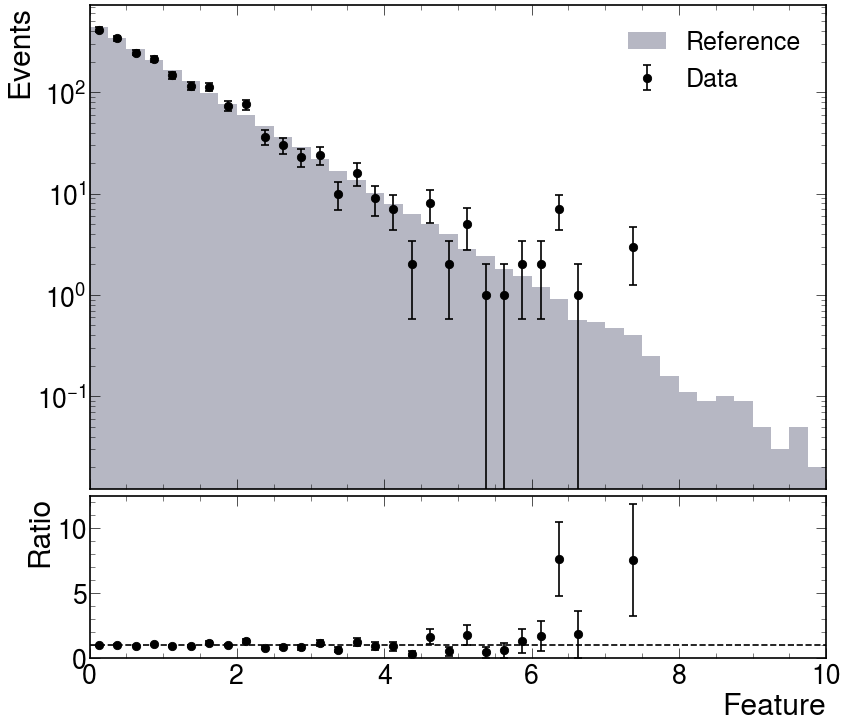

In [20]:
plot_ref_data(
    feature_ref   = feature[target[:, 0] == 0],
    feature_data  = feature[target[:, 0] == 1],
    weights_ref   = target[target[:, 0] == 0, 1],
    weights_data  = target[target[:, 0] == 1, 1],
    figsize       = FIGSIZE,
    bins          = bins,
    ratio         = True,
    fontsize      = FONTSIZE,
    cms           = False,
    color_ref     = PALETTE_2[0],
    color_data    = "black",
    ref_hist_type = "stepfilled",
    ref_label     = "Reference",
    data_label    = "Data",
    ref_alpha     = 0.4,
    xlabel        = "Feature",
    ylabel        = "Events",
    ratio_ylabel  = "Ratio",
    hist_yscale   = "log",
    ratio_yscale  = "linear",
    show_plot     = True,
    save_plot     = False,
    return_fig    = False
)


### Create NPLM model

In [16]:
nplm_model = NPLMnetwork(
    architecture      = ARCHITECTURE,
    activation_func   = ACTIVATION,
    weight_clip_value = WCLIP,
    trainable         = True
)

optimizer = torch.optim.Adam(nplm_model.parameters(), lr=0.001)

nplm_model.to(device)

In [17]:
dof = compute_df(ARCHITECTURE)
print(dof)

13


### Train NPLM model

In [ ]:
# Push to device
feature = feature.to(device)
target  = target.to(device)

In [19]:
losses = []
t_list = []

for epoch in range(1, N_EPOCHS + 1):
    optimizer.zero_grad()  # Zero the gradients
    
    # Forward pass: compute predicted outputs by passing inputs to the model
    pred = nplm_model(feature)
    
    # Calculate the loss
    loss = loss_function(target, pred)
    losses += [loss.item()]
    
    # Calculate test statistic
    t = -2 * loss.item()
    t_list += [t]
    
    # Backward pass: compute gradient of the loss with respect to model parameters
    loss.backward()
    
    # Perform a single optimization step (parameter update)
    optimizer.step()
    
    # Clip the weights
    nplm_model.clip_weights()
    
    # Callback every 1000 epochs
    if epoch % 1000 == 0:
        print(f"Epoch {epoch}/{N_EPOCHS} - Loss: {loss:.4f}")


# After training, you may want to save the final model and the loss history
torch.save(nplm_model.state_dict(), 'nplm_model_final.pth')
torch.save(losses, 'nplm_model_losses.pth')
torch.save(t_list, 'nplm_model_t_list.pth')

Epoch 1000/200000 - Loss: 25.3374
Epoch 2000/200000 - Loss: 1.9186
Epoch 3000/200000 - Loss: -4.5219
Epoch 4000/200000 - Loss: -4.6553
Epoch 5000/200000 - Loss: -4.6830
Epoch 6000/200000 - Loss: -4.7193
Epoch 7000/200000 - Loss: -4.7676
Epoch 8000/200000 - Loss: -4.8378
Epoch 9000/200000 - Loss: -4.9551
Epoch 10000/200000 - Loss: -5.1388
Epoch 11000/200000 - Loss: -5.2562
Epoch 12000/200000 - Loss: -5.3223
Epoch 13000/200000 - Loss: -5.3716
Epoch 14000/200000 - Loss: -5.4167
Epoch 15000/200000 - Loss: -5.4677
Epoch 16000/200000 - Loss: -5.5346
Epoch 17000/200000 - Loss: -5.6340
Epoch 18000/200000 - Loss: -6.3010
Epoch 19000/200000 - Loss: -6.4864
Epoch 20000/200000 - Loss: -6.7059
Epoch 21000/200000 - Loss: -7.0210
Epoch 22000/200000 - Loss: -7.4914
Epoch 23000/200000 - Loss: -8.1853
Epoch 24000/200000 - Loss: -9.1108
Epoch 25000/200000 - Loss: -10.1951
Epoch 26000/200000 - Loss: -11.3410
Epoch 27000/200000 - Loss: -12.4388
Epoch 28000/200000 - Loss: -13.4038
Epoch 29000/200000 - Loss:

### Loss function plot

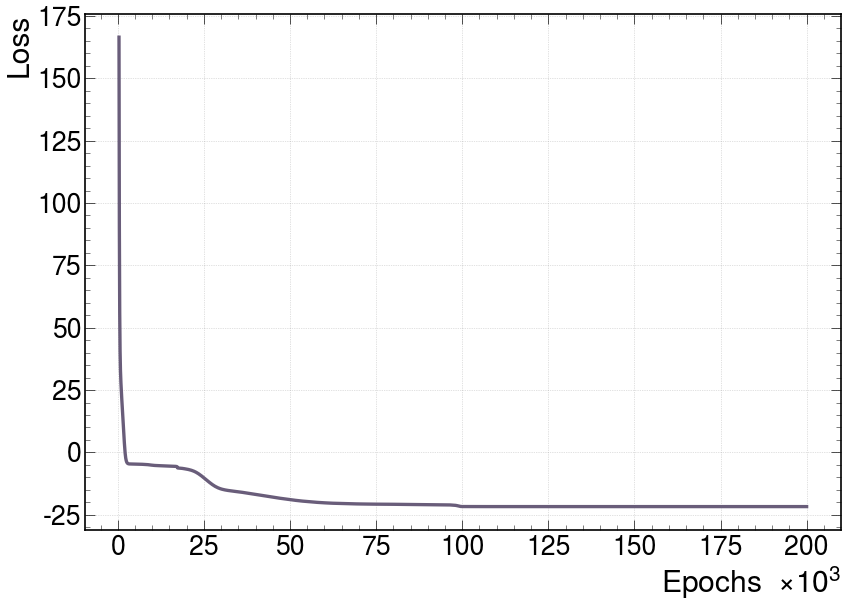

In [20]:
plot_loss_history(
    n_epochs     = N_EPOCHS,
    loss_history = losses,
    epochs_init  = 350,
    epochs_norm  = 1000,
    figsize      = (14, 10),
    fontsize     = FONTSIZE,
    cms          = False,
    color        = PALETTE_2[1],
    xlabel       = r"Epochs $\times 10^3$",
    ylabel       = "Loss",
    show_plot    = True,
    save_plot    = False,
    plot_name    = "1dexpon_loss_history",
    plot_path    = PLOT_PATH,
    plot_format  = "png",
    return_fig   = False
)

### Reconstruction

In [17]:
xgrid = torch.arange(bins[0], bins[-1]+0.01, 0.01).to(device)
feature = feature.to(device)
target  = target.to(device)

with torch.no_grad():
    pred = nplm_model(feature[target[:, 0] == 0])
    grid_pred = nplm_model(xgrid.view(-1, 1))

NameError: name 'nplm_model' is not defined

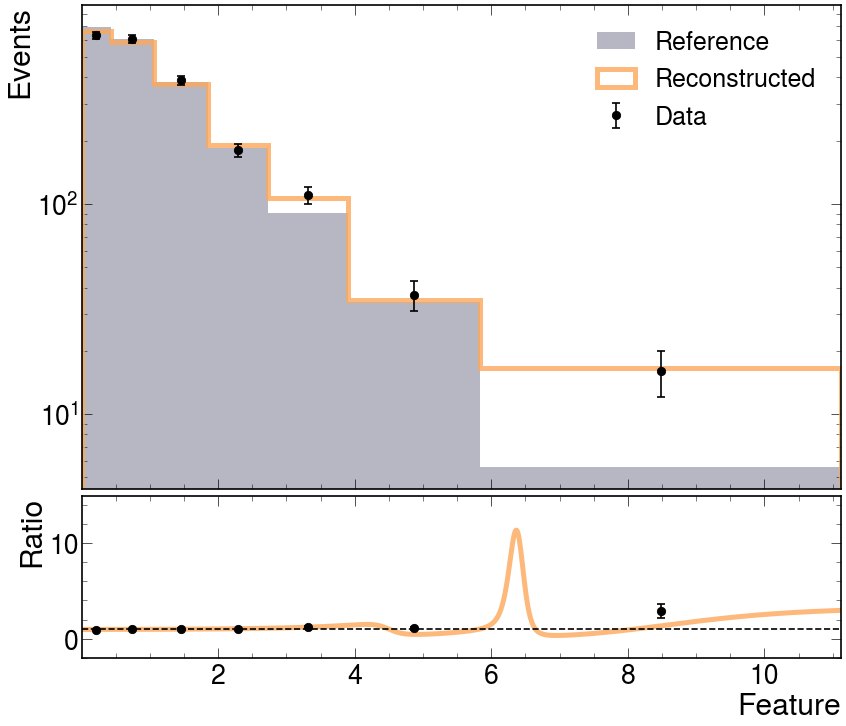

In [ ]:
plot_ref_data_reco(
    feature_ref    = feature[target[:, 0] == 0].cpu(),
    feature_data   = feature[target[:, 0] == 1].cpu(),
    weights_ref    = target[target[:, 0] == 0, 1].cpu(),
    weights_data   = target[target[:, 0] == 1, 1].cpu(),
    prediction_ref = pred.cpu(),
    figsize        = FIGSIZE,
    bins           = bins,
    ratio          = True,
    fontsize       = FONTSIZE,
    cms            = False,
    color_ref      = PALETTE_2[0],
    color_data     = "black",
    ref_hist_type  = "stepfilled",
    pred_hist_type = "step",
    ref_label      = "Reference",
    data_label     = "Data",
    ref_alpha      = 0.4,
    color_reco     = PALETTE_2[4],
    reco_label     = "Reconstructed",
    lw_reco        = 6,
    alpha_reco     = 0.8,
    xlabel         = "Feature",
    ylabel         = "Events",
    ratio_ylabel   = "Ratio",
    hist_yscale    = "log",
    ratio_yscale   = "linear",
    show_plot      = True,
    save_plot      = False,
    plot_name      = "1dexpon_reco_binned_bayesianblocks",
    plot_path      = PLOT_PATH,
    plot_format    = "png",
    return_fig     = False,
    binned_reco    = False,
    grid_reco      = xgrid.cpu(),
    grid_pred      = grid_pred.cpu().detach().numpy(),
)

### Load loss and model

In [21]:
loss_history = torch.load("data/nplm_model_losses.pth")

nplm_model = NPLMnetwork(
    architecture      = ARCHITECTURE,
    activation_func   = ACTIVATION,
    weight_clip_value = WCLIP,
    trainable         = False
)

nplm_model.load_state_dict(torch.load("data/nplm_model_final.pth"))

nplm_model.to(device)

NPLMnetwork(architecture=[1, 4, 1], activation_func=Sigmoid(), weight_clip_value=9)

In [22]:
xgrid = torch.arange(bins[0], bins[-1]+0.01, 0.01).to(device)
feature = feature.to(device)
target  = target.to(device)

with torch.no_grad():
    pred = nplm_model(feature[target[:, 0] == 0])
    grid_pred = nplm_model(xgrid.view(-1, 1))

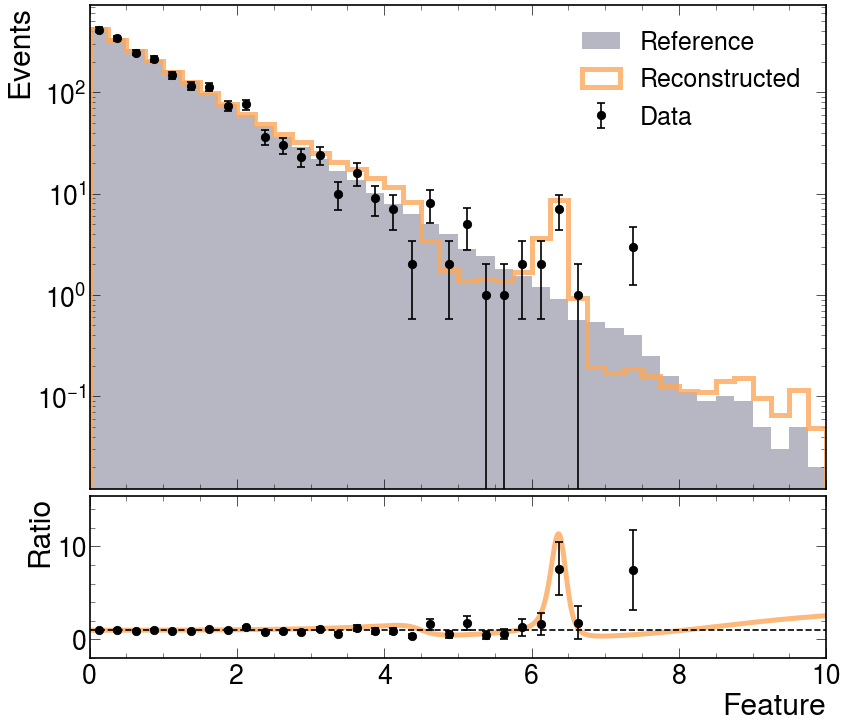

In [23]:
plot_ref_data_reco(
    feature_ref    = feature[target[:, 0] == 0].cpu(),
    feature_data   = feature[target[:, 0] == 1].cpu(),
    weights_ref    = target[target[:, 0] == 0, 1].cpu(),
    weights_data   = target[target[:, 0] == 1, 1].cpu(),
    prediction_ref = pred.cpu(),
    figsize        = FIGSIZE,
    bins           = bins,
    ratio          = True,
    fontsize       = FONTSIZE,
    cms            = False,
    color_ref      = PALETTE_2[0],
    color_data     = "black",
    ref_hist_type  = "stepfilled",
    pred_hist_type = "step",
    ref_label      = "Reference",
    data_label     = "Data",
    ref_alpha      = 0.4,
    color_reco     = PALETTE_2[4],
    reco_label     = "Reconstructed",
    lw_reco        = 6,
    alpha_reco     = 0.8,
    xlabel         = "Feature",
    ylabel         = "Events",
    ratio_ylabel   = "Ratio",
    hist_yscale    = "log",
    ratio_yscale   = "linear",
    show_plot      = True,
    save_plot      = False,
    plot_name      = "1dexpon_reco_binned_bayesianblocks",
    plot_path      = PLOT_PATH,
    plot_format    = "png",
    return_fig     = False,
    binned_reco    = False,
    grid_reco      = xgrid.cpu(),
    grid_pred      = grid_pred.cpu().detach().numpy(),
)

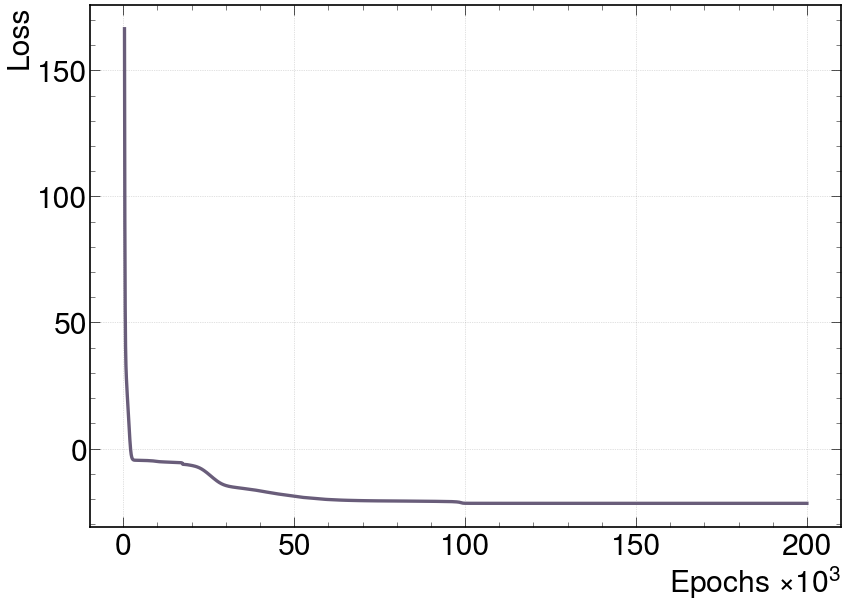

In [26]:
plot_loss_history(
    n_epochs     = N_EPOCHS,
    loss_history = loss_history,
    epochs_init  = 350,
    epochs_norm  = 1000,
    figsize      = (14, 10),
    fontsize     = FONTSIZE,
    cms          = False,
    color        = PALETTE_2[1],
    xlabel       = r"Epochs $\times 10^3$",
    ylabel       = "Loss",
    show_plot    = True,
    save_plot    = False,
    plot_name    = "1dexpon_loss_history",
    plot_path    = PLOT_PATH,
    plot_format  = "png",
    return_fig   = False
)